In [1]:
!pip install opencv-python-headless==4.5.3.56 matplotlib==3.4.3 numpy==1.21.2 pillow==7.0.0 bokeh==2.1.1 torch==1.11.0 torchvision==0.12.0 tqdm==4.63.0 ipywidgets==7.6.5 livelossplot==0.5.4 pytest==7.1.1 pandas==1.3.5 seaborn==0.11.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 9.3 MB/s eta 0:00:00:00:0100:01
  Installing build dependencies ... error
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> [860 lines of output]
      Ignoring numpy: markers 'python_version == "3.6" and platform_machine != "aarch64" and platform_machine != "arm64"' don't match your environment
      Ignoring numpy: markers 'python_version >= "3.6" and sys_platform == "linux" and platform_machine == "aarch64"' don't match your environment
      Ignoring numpy: markers 'python_version >= "3.6" and sys_platform == "darwin" and platform_machine == "arm64"' don't match your environment
      Ignoring numpy: markers 'python_version == "3.7" and platform_machine != "aarch64" and platform_machine != "arm64"' don't match your environment
      Ignoring numpy: markers 'python_version == "3.8" and platform_machine != "aarch64" and platform_machine !

In [2]:
!pip install livelossplot

In [3]:
from io import BytesIO
import urllib.request
from zipfile import ZipFile
import os
import torch
import torch.utils.data
from torchvision import datasets, transforms
from tqdm import tqdm
import multiprocessing
import matplotlib.pyplot as plt


# Let's see if we have an available GPU
import numpy as np
import random


def setup_env():
    use_cuda = torch.cuda.is_available()

    if use_cuda:
        print("GPU available")
    else:
        print("GPU *NOT* available. Will use CPU (slow)")

    # Seed random generator for repeatibility
    seed = 42
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Download data if not present already
    download_and_extract()
    compute_mean_and_std()

    # Make checkpoints subdir if not existing
    os.makedirs("checkpoints", exist_ok=True)
    
    # Make sure we can reach the installed binaries. This is needed for the workspace
    if os.path.exists("/data/DLND/C2/landmark_images"):
        os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"


def get_data_location():
    """
    Find the location of the dataset, either locally or in the Udacity workspace
    """

    if os.path.exists("landmark_images"):
        data_folder = "landmark_images"
    elif os.path.exists("/data/DLND/C2/landmark_images"):
        data_folder = "/data/DLND/C2/landmark_images"
    else:
        raise IOError("Please download the dataset first")

    return data_folder


def download_and_extract(
    url="https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip",
):
    
    try:
        
        location = get_data_location()
    
    except IOError:
        # Dataset does not exist
        print(f"Downloading and unzipping {url}. This will take a while...")

        with urllib.request.urlopen(url) as resp:

            with ZipFile(BytesIO(resp.read())) as fp:

                fp.extractall(".")

        print("done")
                
    else:
        
        print(
            "Dataset already downloaded. If you need to re-download, "
            f"please delete the directory {location}"
        )
        return None


# Compute image normalization
def compute_mean_and_std():
    """
    Compute per-channel mean and std of the dataset (to be used in transforms.Normalize())
    """

    cache_file = "mean_and_std.pt"
    if os.path.exists(cache_file):
        print(f"Reusing cached mean and std")
        d = torch.load(cache_file)

        return d["mean"], d["std"]

    folder = get_data_location()
    ds = datasets.ImageFolder(
        folder, transform=transforms.Compose([transforms.ToTensor()])
    )
    dl = torch.utils.data.DataLoader(
        ds, batch_size=1, num_workers=0
    )

    mean = 0.0
    for images, _ in tqdm(dl, total=len(ds), desc="Computing mean", ncols=80):
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
    mean = mean / len(dl.dataset)

    var = 0.0
    npix = 0
    for images, _ in tqdm(dl, total=len(ds), desc="Computing std", ncols=80):
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        var += ((images - mean.unsqueeze(1)) ** 2).sum([0, 2])
        npix += images.nelement()

    std = torch.sqrt(var / (npix / 3))

    # Cache results so we don't need to redo the computation
    torch.save({"mean": mean, "std": std}, cache_file)

    return mean, std


def after_subplot(ax: plt.Axes, group_name: str, x_label: str):
    """Add title xlabel and legend to single chart"""
    ax.set_title(group_name)
    ax.set_xlabel(x_label)
    ax.legend(loc="center right")

    if group_name.lower() == "loss":
        ax.set_ylim([None, 4.5])


def plot_confusion_matrix(pred, truth):
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np

    gt = pd.Series(truth, name='Ground Truth')
    predicted = pd.Series(pred, name='Predicted')

    confusion_matrix = pd.crosstab(gt, predicted)

    fig, sub = plt.subplots(figsize=(14, 12))
    with sns.plotting_context("notebook"):
        idx = (confusion_matrix == 0)
        confusion_matrix[idx] = np.nan
        sns.heatmap(confusion_matrix, annot=True, ax=sub, linewidths=0.5, linecolor='lightgray', cbar=False)

In [4]:
setup_env()

GPU available
Dataset already downloaded. If you need to re-download, please delete the directory landmark_images
Reusing cached mean and std


In [5]:
from io import BytesIO
import urllib.request
from zipfile import ZipFile
import os
import torch
import torch.utils.data
from torchvision import datasets, transforms
from tqdm import tqdm
import multiprocessing
import matplotlib.pyplot as plt


# Let's see if we have an available GPU
import numpy as np
import random


def setup_env():
    use_cuda = torch.cuda.is_available()

    if use_cuda:
        print("GPU available")
    else:
        print("GPU *NOT* available. Will use CPU (slow)")

    # Seed random generator for repeatibility
    seed = 42
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Download data if not present already
    download_and_extract()
    compute_mean_and_std()

    # Make checkpoints subdir if not existing
    os.makedirs("checkpoints", exist_ok=True)
    
    # Make sure we can reach the installed binaries. This is needed for the workspace
    if os.path.exists("/data/DLND/C2/landmark_images"):
        os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"


def get_data_location():
    """
    Find the location of the dataset, either locally or in the Udacity workspace
    """

    if os.path.exists("landmark_images"):
        data_folder = "landmark_images"
    elif os.path.exists("/data/DLND/C2/landmark_images"):
        data_folder = "/data/DLND/C2/landmark_images"
    else:
        raise IOError("Please download the dataset first")

    return data_folder


def download_and_extract(
    url="https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip",
):
    
    try:
        
        location = get_data_location()
    
    except IOError:
        # Dataset does not exist
        print(f"Downloading and unzipping {url}. This will take a while...")

        with urllib.request.urlopen(url) as resp:

            with ZipFile(BytesIO(resp.read())) as fp:

                fp.extractall(".")

        print("done")
                
    else:
        
        print(
            "Dataset already downloaded. If you need to re-download, "
            f"please delete the directory {location}"
        )
        return None


# Compute image normalization
def compute_mean_and_std():
    """
    Compute per-channel mean and std of the dataset (to be used in transforms.Normalize())
    """

    cache_file = "mean_and_std.pt"
    if os.path.exists(cache_file):
        print(f"Reusing cached mean and std")
        d = torch.load(cache_file)

        return d["mean"], d["std"]

    folder = get_data_location()
    ds = datasets.ImageFolder(
        folder, transform=transforms.Compose([transforms.ToTensor()])
    )
    dl = torch.utils.data.DataLoader(
        ds, batch_size=1, num_workers=0
    )

    mean = 0.0
    for images, _ in tqdm(dl, total=len(ds), desc="Computing mean", ncols=80):
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
    mean = mean / len(dl.dataset)

    var = 0.0
    npix = 0
    for images, _ in tqdm(dl, total=len(ds), desc="Computing std", ncols=80):
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        var += ((images - mean.unsqueeze(1)) ** 2).sum([0, 2])
        npix += images.nelement()

    std = torch.sqrt(var / (npix / 3))

    # Cache results so we don't need to redo the computation
    torch.save({"mean": mean, "std": std}, cache_file)

    return mean, std


def after_subplot(ax: plt.Axes, group_name: str, x_label: str):
    """Add title xlabel and legend to single chart"""
    ax.set_title(group_name)
    ax.set_xlabel(x_label)
    ax.legend(loc="center right")

    if group_name.lower() == "loss":
        ax.set_ylim([None, 4.5])


def plot_confusion_matrix(pred, truth):
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np

    gt = pd.Series(truth, name='Ground Truth')
    predicted = pd.Series(pred, name='Predicted')

    confusion_matrix = pd.crosstab(gt, predicted)

    fig, sub = plt.subplots(figsize=(14, 12))
    with sns.plotting_context("notebook"):
        idx = (confusion_matrix == 0)
        confusion_matrix[idx] = np.nan
        sns.heatmap(confusion_matrix, annot=True, ax=sub, linewidths=0.5, linecolor='lightgray', cbar=False)

In [6]:
import math
import torch
import torch.utils.data
from pathlib import Path
from torchvision import datasets, transforms
import torchvision.transforms as T
import multiprocessing

# from .helpers import compute_mean_and_std, get_data_location
import matplotlib.pyplot as plt


def get_data_loaders(
    batch_size: int = 32, valid_size: float = 0.2, num_workers: int = 1, limit: int = -1
):
    """
    Create and returns the train_one_epoch, validation and test data loaders.

    :param batch_size: size of the mini-batches
    :param valid_size: fraction of the dataset to use for validation. For example 0.2
                       means that 20% of the dataset will be used for validation
    :param num_workers: number of workers to use in the data loaders. Use num_workers=1. 
    :param limit: maximum number of data points to consider
    :return a dictionary with 3 keys: 'train_one_epoch', 'valid' and 'test' containing respectively the
            train_one_epoch, validation and test data loaders
    """

    # We will fill this up later
    data_loaders = {"train": None, "valid": None, "test": None}

    base_path = Path(get_data_location())

    # Compute mean and std of the dataset
    mean, std = compute_mean_and_std()
    print(f"Dataset mean: {mean}, std: {std}")

    # YOUR CODE HERE:
    # create 3 sets of data transforms: one for the training dataset,
    # containing data augmentation, one for the validation dataset
    # (without data augmentation) and one for the test set (again
    # without augmentation)
    # HINT: resize the image to 256 first, then crop them to 224, then add the
    # appropriate transforms for that step
#     data_transforms = get_transforms(mean, std, rand_augment_magnitude=9)
    data_transforms = {
        "train": T.Compose(
            [
                T.Resize(256),
                T.RandomCrop(224),
                T.RandomHorizontalFlip(0.5),
                T.RandAugment(
                    num_ops=2,
                    magnitude=9,
                    interpolation=T.InterpolationMode.BILINEAR,
                ),
                T.ToTensor(),
                T.Normalize(mean, std),
            ]
        ),
        "valid": T.Compose(
            [
                T.Resize(256),
                T.RandomCrop(224),
                T.ToTensor(),
                T.Normalize(mean, std),
            ]
        ),
        "test": T.Compose(
            [
                T.Resize(256),
                T.RandomCrop(224),
                T.ToTensor(),
                T.Normalize(mean, std),
            ]
        ),
    }

    # Create train and validation datasets
    train_data = datasets.ImageFolder(
        base_path / "train",
        # YOUR CODE HERE: add the appropriate transform that you defined in
        # the data_transforms dictionary
        transform = data_transforms['train']
    )
    # The validation dataset is a split from the train_one_epoch dataset, so we read
    # from the same folder, but we apply the transforms for validation
    valid_data = datasets.ImageFolder(
        base_path / "train",
        # YOUR CODE HERE: add the appropriate transform that you defined in
        # the data_transforms dictionary
        transform = data_transforms['valid']
    )

    # obtain training indices that will be used for validation
    n_tot = len(train_data)
    indices = torch.randperm(n_tot)

    # If requested, limit the number of data points to consider
    if limit > 0:
        indices = indices[:limit]
        n_tot = limit

    split = int(math.ceil(valid_size * n_tot))
    train_idx, valid_idx = indices[split:], indices[:split]

    # define samplers for obtaining training and validation batches
    train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
    valid_sampler  = torch.utils.data.SubsetRandomSampler(valid_idx)

    # prepare data loaders
    data_loaders["train"] = torch.utils.data.DataLoader(
        train_data,
        batch_size=batch_size,
        sampler=train_sampler,
        num_workers=num_workers,
    )
    data_loaders["valid"] = torch.utils.data.DataLoader(
        # YOUR CODE HERE
        valid_data,
        batch_size=batch_size,
        sampler=valid_sampler,
        num_workers=num_workers,
    )

    # Now create the test data loader
    test_data = datasets.ImageFolder(
        base_path / "test",
        # YOUR CODE HERE (add the test transform)
        transform=data_transforms['test']
    )

    if limit > 0:
        indices = torch.arange(limit)
        test_sampler = torch.utils.data.SubsetRandomSampler(indices)
    else:
        test_sampler = None

    data_loaders["test"] = torch.utils.data.DataLoader(
        # YOUR CODE HERE (remember to add shuffle=False as well)
        test_data,
        batch_size=batch_size,
        sampler=test_sampler,
        num_workers=num_workers,
        shuffle=False
    )

    return data_loaders


def visualize_one_batch(data_loaders, max_n: int = 5):
    """
    Visualize one batch of data.

    :param data_loaders: dictionary containing data loaders
    :param max_n: maximum number of images to show
    :return: None
    """

    # YOUR CODE HERE:
    # obtain one batch of training images
    # First obtain an iterator from the train dataloader
    dataiter  = iter(data_loaders['train'])# YOUR CODE HERE
    # Then call the .next() method on the iterator you just
    # obtained
    images, labels  = dataiter.next()# YOUR CODE HERE

    # Undo the normalization (for visualization purposes)
    mean, std = compute_mean_and_std()
    invTrans = transforms.Compose(
        [
            transforms.Normalize(mean=[0.0, 0.0, 0.0], std=1 / std),
            transforms.Normalize(mean=-mean, std=[1.0, 1.0, 1.0]),
        ]
    )

    images = invTrans(images)

    # YOUR CODE HERE:
    # Get class names from the train data loader
    class_names  = data_loaders['train'].dataset.classes # YOUR CODE HERE

    # Convert from BGR (the format used by pytorch) to
    # RGB (the format expected by matplotlib)
    images = torch.permute(images, (0, 2, 3, 1)).clip(0, 1)

    # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(25, 4))
    for idx in range(max_n):
        ax = fig.add_subplot(1, max_n, idx + 1, xticks=[], yticks=[])
        ax.imshow(images[idx])
        # print out the correct label for each image
        # .item() gets the value contained in a Tensor
        ax.set_title(class_names[labels[idx].item()])

In [7]:
# data_loaders = get_data_loaders(batch_size=5,valid_size=0.01)# YOUR CODE HERE

# visualize_one_batch(data_loaders)

In [18]:
import torch
import torch.nn as nn

# define the CNN architecture
class MyModel(nn.Module):
    def __init__(self, num_classes: int = 1000, dropout: float = 0.7) -> None:

        super().__init__()

        # YOUR CODE HERE
        # Define a CNN architecture. Remember to use the variable num_classes
        # to size appropriately the output of your classifier, and if you use
        # the Dropout layer, use the variable "dropout" to indicate how much
        # to use (like nn.Dropout(p=dropout))
        
        self.backbone = nn.Sequential(
                                        nn.Conv2d(3,16,kernel_size=3,padding=1,stride=1),
#                                         nn.Dropout2d(0.4), 
                                        nn.BatchNorm2d(16),
                                        nn.LeakyReLU(negative_slope = 0.2),
                                        nn.MaxPool2d(2,2), 

                                        nn.Conv2d(16,32,kernel_size=3,padding=1,stride=1),
#                                         nn.Dropout2d(0.4), 
                                        nn.BatchNorm2d(32),
                                        nn.LeakyReLU(negative_slope = 0.2),
                                        nn.MaxPool2d(2,2), 

                                        nn.Conv2d(32,64,kernel_size=3,padding=1,stride=1),
#                                         nn.Dropout2d(0.2), 
                                        nn.BatchNorm2d(64),
                                        nn.LeakyReLU(negative_slope = 0.2),
                                        nn.MaxPool2d(2,2),
            
                                        nn.Conv2d(64,128,kernel_size=3,padding=1,stride=1),
#                                         nn.Dropout2d(0.2), 
                                        nn.BatchNorm2d(128),
                                        nn.LeakyReLU(negative_slope = 0.2),
                                        nn.MaxPool2d(2,2),
                                        
                                        nn.Flatten()
                                    )
        
        
        self.head = nn.Sequential(
                                    nn.Linear(128*14*14, 512),
                                    nn.Dropout(0.4),
                                    nn.BatchNorm1d(512),
                                    nn.LeakyReLU(negative_slope = 0.2),

#                                     nn.Linear(28*28,256),
#                                     nn.Dropout(0.2),
#                                     nn.BatchNorm1d(256),
#                                     nn.ReLU(),
                                    
                                    nn.Linear(512,num_classes)
                                )
            
                                      

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # YOUR CODE HERE: process the input tensor through the
        # feature extractor, the pooling and the final linear
        # layers (if appropriate for the architecture chosen)
        
        x = self.backbone(x)
#         x = self.flatten(x)
        x = self.head(x)
        
        return x


In [9]:
import torch
import torch.nn as nn
import torch.optim


def get_loss():
    """
    Get an instance of the CrossEntropyLoss (useful for classification),
    optionally moving it to the GPU if use_cuda is set to True
    """

    # YOUR CODE HERE: select a loss appropriate for classification
    loss  = nn.CrossEntropyLoss() # YOUR CODE HERE

    return loss


def get_optimizer(
    model: nn.Module,
    optimizer: str = "SGD",
    learning_rate: float = 0.01,
    momentum: float = 0.5,
    weight_decay: float = 0,
):
    """
    Returns an optimizer instance

    :param model: the model to optimize
    :param optimizer: one of 'SGD' or 'Adam'
    :param learning_rate: the learning rate
    :param momentum: the momentum (if the optimizer uses it)
    :param weight_decay: regularization coefficient
    """
    if optimizer.lower() == "sgd":
        # YOUR CODE HERE: create an instance of the SGD
        # optimizer. Use the input parameters learning_rate, momentum
        # and weight_decay
        opt = torch.optim.SGD(
            # YOUR CODE HERE
            model.parameters(),
            lr = learning_rate,
            momentum = momentum,
            weight_decay = weight_decay
        )

    elif optimizer.lower() == "adam":
        # YOUR CODE HERE: create an instance of the Adam
        # optimizer. Use the input parameters learning_rate, momentum
        # and weight_decay
        opt = torch.optim.Adam(
            # YOUR CODE HERE
            model.parameters(),
            lr = learning_rate,
            weight_decay = weight_decay
        )
    else:
        raise ValueError(f"Optimizer {optimizer} not supported")

    return opt



In [10]:
import tempfile

import torch
import numpy as np
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot
from tqdm import tqdm
# from src.helpers import after_subplot


def train_one_epoch(train_dataloader, model, optimizer, loss):
    """
    Performs one train_one_epoch epoch
    """

    if torch.cuda.is_available():
        # YOUR CODE HERE: transfer the model to the GPU
        # HINT: use .cuda()
        model.cuda()

    # YOUR CODE HERE: set the model to training mode
    model.train()
    train_loss = 0.0

    for batch_idx, (data, target) in tqdm(
        enumerate(train_dataloader),
        desc="Training",
        total=len(train_dataloader),
        leave=True,
        ncols=80,
    ):
        # move data to GPU
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()

        # 1. clear the gradients of all optimized variables
        # YOUR CODE HERE:
        optimizer.zero_grad()
        # 2. forward pass: compute predicted outputs by passing inputs to the model
        output  = model(data) # YOUR CODE HERE
        # 3. calculate the loss
        loss_value  = loss(output,target)# YOUR CODE HERE
        # 4. backward pass: compute gradient of the loss with respect to model parameters
        # YOUR CODE HERE:
        loss_value.backward()
        # 5. perform a single optimization step (parameter update)
        # YOUR CODE HERE:
        optimizer.step()
        # update average training loss
        train_loss = train_loss + (
            (1 / (batch_idx + 1)) * (loss_value.data.item() - train_loss)
        )

    return train_loss


def valid_one_epoch(valid_dataloader, model, loss):
    """
    Validate at the end of one epoch
    """

    with torch.no_grad():

        # set the model to evaluation mode
        # YOUR CODE HERE
        model.eval()
        
        if torch.cuda.is_available():
            model.cuda()

        valid_loss = 0.0
        for batch_idx, (data, target) in tqdm(
            enumerate(valid_dataloader),
            desc="Validating",
            total=len(valid_dataloader),
            leave=True,
            ncols=80,
        ):
            # move data to GPU
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()

            # 1. forward pass: compute predicted outputs by passing inputs to the model
            output  = model(data) # YOUR CODE HERE
            # 2. calculate the loss
            loss_value  = loss(output,target) # YOUR CODE HERE

            # Calculate average validation loss
            valid_loss = valid_loss + (
                (1 / (batch_idx + 1)) * (loss_value.data.item() - valid_loss)
            )

    return valid_loss


def optimize(data_loaders, model, optimizer, loss, n_epochs, save_path, interactive_tracking=False):
    # initialize tracker for minimum validation loss
    if interactive_tracking:
        liveloss = PlotLosses(outputs=[MatplotlibPlot(after_subplot=after_subplot)])
    else:
        liveloss = None

    valid_loss_min = None
    logs = {}

    # Learning rate scheduler: setup a learning rate scheduler that
    # reduces the learning rate when the validation loss reaches a
    # plateau
    # HINT: look here: 
    # https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
    scheduler  = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                            mode='min',
                                                            factor=0.5,
                                                            patience=2,
                                                            threshold=1e-2,
                                                            verbose=True
                                                           ) # YOUR CODE HERE

    for epoch in range(1, n_epochs + 1):

        train_loss = train_one_epoch(
            data_loaders["train"], model, optimizer, loss
        )

        valid_loss = valid_one_epoch(data_loaders["valid"], model, loss)

        # print training/validation statistics
        print(
            "Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}".format(
                epoch, train_loss, valid_loss
            )
        )

        # If the validation loss decreases by more than 1%, save the model
        if valid_loss_min is None or (
                (valid_loss_min - valid_loss) / valid_loss_min > 0.01
        ):
            print(f"New minimum validation loss: {valid_loss:.6f}. Saving model ...")

            # Save the weights to save_path
            # YOUR CODE HERE
            torch.save(model.state_dict(),save_path)
            valid_loss_min = valid_loss

        # Update learning rate, i.e., make a step in the learning rate scheduler
        # YOUR CODE HERE
        scheduler.step(valid_loss)
        # Log the losses and the current learning rate
        if interactive_tracking:
            logs["loss"] = train_loss
            logs["val_loss"] = valid_loss
            logs["lr"] = optimizer.param_groups[0]["lr"]

            liveloss.update(logs)
            liveloss.send()


def one_epoch_test(test_dataloader, model, loss):
    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    with torch.no_grad():

        # set the model to evaluation mode
        # YOUR CODE HERE
        model.eval()
        if torch.cuda.is_available():
            model = model.cuda()

        for batch_idx, (data, target) in tqdm(
                enumerate(test_dataloader),
                desc='Testing',
                total=len(test_dataloader),
                leave=True,
                ncols=80
        ):
            # move data to GPU
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()

            # 1. forward pass: compute predicted outputs by passing inputs to the model
            logits  = model(data)# YOUR CODE HERE
            # 2. calculate the loss
            loss_value  = loss(logits,target)# YOUR CODE HERE

            # update average test loss
            test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss_value.data.item() - test_loss))

            # convert logits to predicted class
            # HINT: the predicted class is the index of the max of the logits
            pred  = torch.argmax(logits,dim=1)# YOUR CODE HERE

            # compare predictions to true label
            correct += torch.sum(torch.squeeze(pred.eq(target.data.view_as(pred))).cpu())
            total += data.size(0)

    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

    return test_loss


   

In [16]:
batch_size = 64         # size of the minibatch for stochastic gradient descent (or Adam)
valid_size = 0.2        # fraction of the training data to reserve for validation
num_epochs = 80         # number of epochs for training
num_classes = 50        # number of classes. Do not change this
dropout = 0.2           # dropout for our model
learning_rate = 0.005   # Learning rate for SGD (or Adam)
opt = 'adam'            # optimizer. 'sgd' or 'adam'
weight_decay = 0        # regularization. Increase th
momentum = 0.9

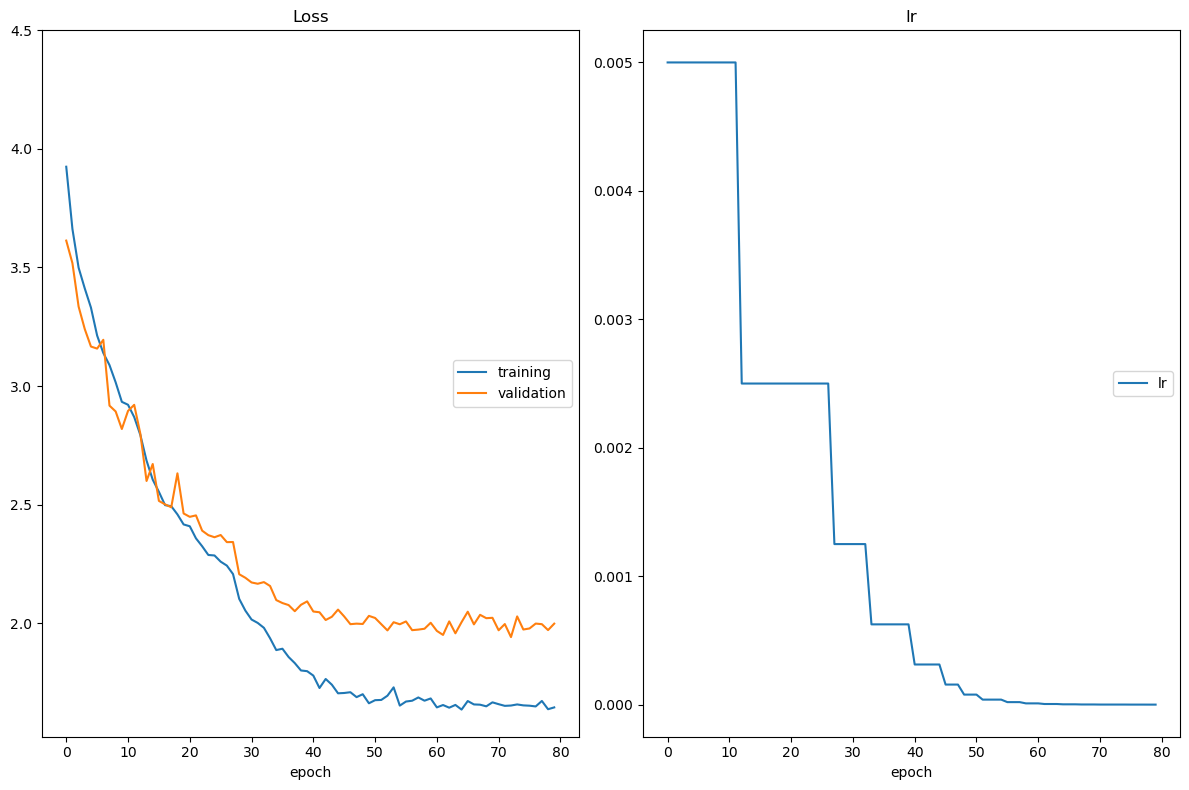

In [19]:
# from src.data import get_data_loaders
# from src.train import optimize
# from src.optimization import get_optimizer, get_loss
# from src.model import MyModel

# get the data loaders using batch_size and valid_size defined in the previous
# cell
# HINT: do NOT copy/paste the values. Use the variables instead
data_loaders = get_data_loaders(batch_size=batch_size, valid_size=valid_size)# YOUR CODE HERE

# instance model MyModel with num_classes and drouput defined in the previous
# cell
model = MyModel(num_classes,dropout) # YOUR CODE HERE

# Get the optimizer using get_optimizer and the model you just created, the learning rate,
# the optimizer and the weight decay specified in the previous cell
optimizer = get_optimizer(model=model, optimizer=opt, learning_rate=learning_rate, weight_decay=weight_decay) # YOUR CODE HERE

# Get the loss using get_loss
loss = get_loss() # YOUR CODE HERE

optimize(
    data_loaders,
    model,
    optimizer,
    loss,
    n_epochs=num_epochs,
    save_path="best_val_loss.pt",
    interactive_tracking=True
)

In [20]:
# load the model that got the best validation accuracy
import torch

model = MyModel(num_classes=num_classes, dropout=dropout)

# YOUR CODE HERE: load the weights in 'checkpoints/best_val_loss.pt'
model.load_state_dict(torch.load('best_val_loss.pt'))
# Run test
one_epoch_test(data_loaders['test'], model, loss)

Testing: 100%|██████████████████████████████████| 20/20 [00:10<00:00,  1.89it/s]

Test Loss: 1.835772


Test Accuracy: 53% (665/1250)


1.8357716858386992

In [ ]:
import os

import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm
from torchvision import datasets
import torchvision.transforms as T
# from .helpers import get_data_location


class Predictor(nn.Module):

    def __init__(self, model, class_names, mean, std):
        super().__init__()

        self.model = model.eval()
        self.class_names = class_names

        # We use nn.Sequential and not nn.Compose because the former
        # is compatible with torch.script, while the latter isn't
        self.transforms = nn.Sequential(
            T.Resize([256, ]),  # We use single int value inside a list due to torchscript type restrictions
            T.CenterCrop(224),
            T.ConvertImageDtype(torch.float),
            T.Normalize(mean.tolist(), std.tolist())
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            # 1. apply transforms
            x  = self.transfroms(x) # YOUR CODE HERE
            # 2. get the logits
            x  = self.model(x) # YOUR CODE HERE
            # 3. apply softmax
            #    HINT: remmeber to apply softmax across dim=1
            softmax_layer = nn.Softmax(dim=1)
            x  = softmax_layer(x) # YOUR CODE HERE

            return x


def predictor_test(test_dataloader, model_reloaded):
    """
    Test the predictor. Since the predictor does not operate on the same tensors
    as the non-wrapped model, we need a specific test function (can't use one_epoch_test)
    """

    folder = get_data_location()
    test_data = datasets.ImageFolder(os.path.join(folder, "test"), transform=T.ToTensor())

    pred = []
    truth = []
    for x in tqdm(test_data, total=len(test_dataloader.dataset), leave=True, ncols=80):
        softmax = model_reloaded(x[0].unsqueeze(dim=0))

        idx = softmax.squeeze().argmax()

        pred.append(int(x[1]))
        truth.append(int(idx))

    pred = np.array(pred)
    truth = np.array(truth)

    print(f"Accuracy: {(pred==truth).sum() / pred.shape[0]}")

    return truth, pred



In [ ]:
# NOTE: you might need to restart the notebook before running this step
# If you get an error about RuntimeError: Can't redefine method: forward on class
# restart your notebook then execute only this cell
# from src.predictor import Predictor
# from src.helpers import compute_mean_and_std
# from src.model import MyModel
# from src.data import get_data_loaders
import torch

data_loaders = get_data_loaders(batch_size=1)

# First let's get the class names from our data loaders
class_names = data_loaders["train"].dataset.classes

# Then let's move the model_transfer to the CPU
# (we don't need GPU for inference)
model = MyModel(num_classes=50, dropout=0.5).cpu()

# Let's make sure we use the right weights by loading the
# best weights we have found during training
# NOTE: remember to use map_location='cpu' so the weights
# are loaded on the CPU (and not the GPU)

# YOUR CODE HERE
model.load(torch.load('best_val_loss.pt',map_location='cpu'))
# Let's wrap our model using the predictor class
mean, std = compute_mean_and_std()
predictor = Predictor(model, class_names, mean, std).cpu()

# Export using torch.jit.script
scripted_predictor = torch.jit.script(predictor) # YOUR CODE HERE

scripted_predictor.save("original_exported.pt")